# Imports of modules

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pandas as pd

%matplotlib inline

# Loading data

You can download it from [Kaggle site](https://www.kaggle.com/c/whats-cooking/data)

In [2]:
data = pd.read_json('data/train.json')
print('recipes: ', data.shape[0])
print('cuisines', sorted(set(data.cuisine)))

recipes:  39774
cuisines ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']


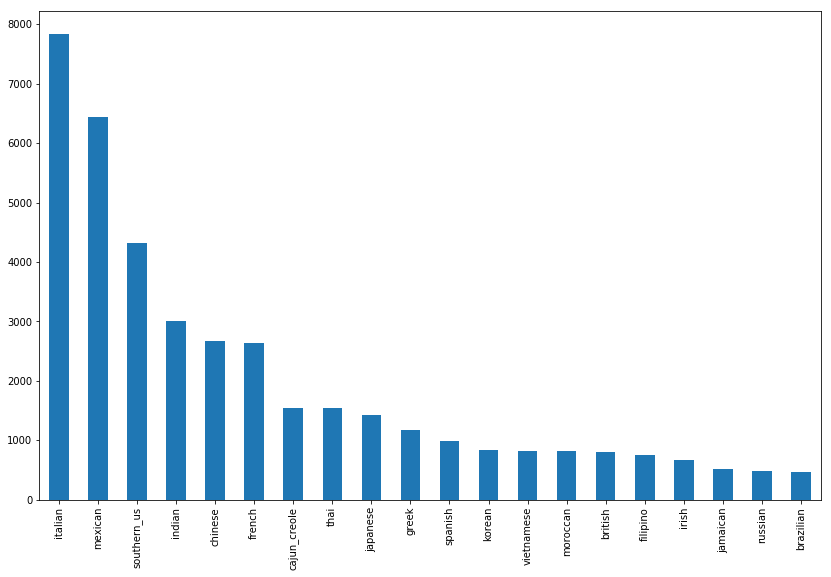

In [3]:
fig = plt.figure(figsize=(14, 9))
data.cuisine.value_counts().plot(kind='bar')

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

recipes = [
    'salt, sugar, black pepper',
    'cucumber, carrot, salt'
]

vect = CountVectorizer()
vectors = vect.fit_transform(recipes).todense()

pd.DataFrame(data=vectors, columns=sorted(vect.vocabulary_))

,black,carrot,cucumber,pepper,salt,sugar
0,1,0,0,1,1,1
1,0,1,1,0,1,0


In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

trans = TfidfTransformer()
tfidf = trans.fit_transform(vectors)

pd.DataFrame(data=tfidf.todense(), columns=sorted(vect.vocabulary_)).applymap(lambda x: '%.3f' % x)

,black,carrot,cucumber,pepper,salt,sugar
0,0.534,0.000,0.000,0.534,0.380,0.534
1,0.000,0.632,0.632,0.000,0.449,0.000


In [6]:
from nltk import regexp_tokenize
from nltk.stem.snowball import SnowballStemmer


class StemmerTokenizer(object):
    """
    Joins all ingredients into a single string and provides
    a list of stems of all words longer than 2 letters.
    
    Example:
    >>> tok = StemmerTokenizer()
    >>> tok.tokenizer(
            tok.preprocessor([
                'romaine lettuce', 'black olives', 'grape tomatoes',
                'garlic', 'pepper', 'purple onion', 'seasoning',
                'garbanzo beans', 'feta cheese crumbles'
            ])
        )
    ['romain', 'lettuc', 'black', 'oliv', 'grape', 'tomato',
     'garlic', 'pepper', 'purpl', 'onion', 'season',
     'garbanzo', 'bean', 'feta', 'chees', 'crumbl']
    """

    def __init__(self):
        self.pattern = r'(?u)\b[a-zA-Z_][a-zA-Z_]+\b'
        self.stemmer = SnowballStemmer('english')

    def mapper(self, word):
        return self.stemmer.stem(word)

    def tokenizer(self, doc):
        return [self.mapper(t) for t in regexp_tokenize(doc, pattern=self.pattern)]

    def preprocessor(self, line):
        return ' '.join(line).lower()

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
    
tokenizerClass = StemmerTokenizer

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        preprocessor=tokenizerClass().preprocessor,
        tokenizer=tokenizerClass().tokenizer,
        stop_words='english',
        max_df=1.0,
        min_df=1,
        binary=True,
    )),
    ('transformer', TfidfTransformer()),
    ('classifier', LinearSVC(
        C=0.78, penalty='l2', loss='squared_hinge', dual=True, max_iter=1000, random_state=0))
])

In [8]:
# Takes around 50s
train = pd.read_json('data/train.json')
X_train = train['ingredients']
y_train = train['cuisine']

test = pd.read_json('data/test.json')
X_test = test['ingredients']

pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

In [9]:
prediction

array(['irish', 'southern_us', 'italian', ..., 'italian', 'southern_us',
       'mexican'], dtype=object)

In [23]:
from sklearn.model_selection import cross_val_score

In [10]:
cv_scores = cross_val_score(pipeline, X_train, y=y_train, cv=5)
print("Accuracy: %0.5f (+/- %0.5f)" % (cv_scores.mean(), cv_scores.std() * 2))

Accuracy: 0.78790 (+/- 0.00854)


# Weighted classes

In [11]:
rng = np.random.RandomState(5)
n_samples_1 = 400
n_samples_2 = 40
X = np.r_[1.5 * rng.randn(n_samples_1, 2),
          0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y = [0] * (n_samples_1) + [1] * (n_samples_2)

In [12]:
# fit the model and get the separating hyperplane
clf = SVC(kernel='linear', C=1.0)
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
def line_for_clf(clf, n):
    w = clf.coef_[n]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - clf.intercept_[0] / w[1]
    return xx,yy

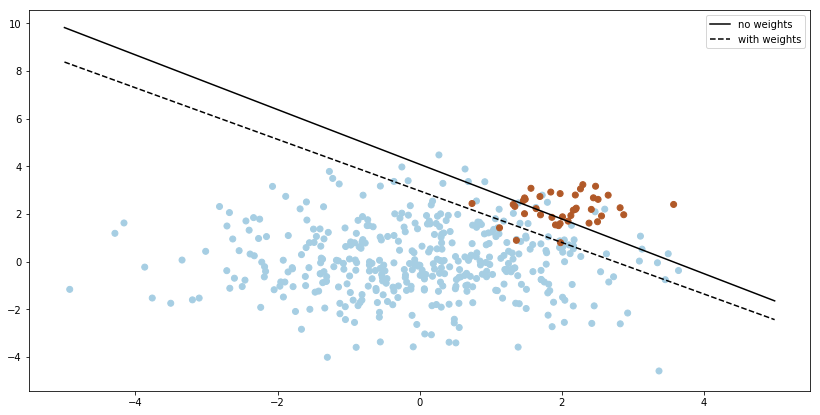

In [14]:
fig = plt.figure(figsize=(14,7))
xx, yy = line_for_clf(clf, 0)
# wclf = SVC(kernel='linear', class_weight={1: 10})
wclf = SVC(kernel='linear', class_weight='balanced')
wclf.fit(X, y)
xx, wyy = line_for_clf(wclf, 0)
# plot separating hyperplanes and samples
h0 = plt.plot(xx, yy, 'k-', label='no weights')
h1 = plt.plot(xx, wyy, 'k--', label='with weights')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.legend()
plt.axis('tight')
plt.show()

# If we use several classes

In [15]:
rng = np.random.RandomState(5)
n_samples_1 = n_samples_2 = n_samples_3 = 40
X = np.r_[1.5 * rng.randn(n_samples_1, 2),
          0.5 * rng.randn(n_samples_2, 2) + [2, 2],
          0.2 * rng.randn(n_samples_3, 2) + [3, -1]]
y = [0] * (n_samples_1) + [1] * (n_samples_2) + [2] * (n_samples_3)

In [16]:
from matplotlib.colors import ListedColormap
# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
def plot_estimator(estimator, X, y):
    try:
        X, y = X.values, y.values
    except AttributeError:
        pass  
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

In [17]:
three_clf = SVC(C=20, kernel='linear',decision_function_shape='ovr')

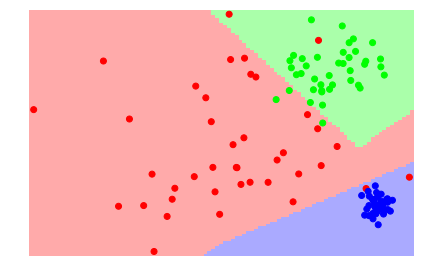

In [18]:
plot_estimator(three_clf, X, y)

Clearly, some of these classes are not linearly separable.

As we learned, regularization is tuned via the $C$ parameter. In practice, a large $C$ value means that the number of support vectors is small (less regularization), while a small $C$ implies many support vectors (more regularization). scikit-learn sets a default value of $C=1$.

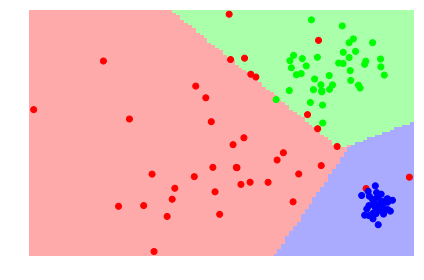

In [19]:
from IPython.html.widgets import interact

@interact(power=[-2, 5])
def plot_regularized(power):
    svc = SVC(kernel='linear', C=10**power, decision_function_shape='ovr')
    plot_estimator(svc, X, y)

We can choose from a suite of available kernels (`linear`, `poly`, `rbf`, `sigmoid`, `precomputed`) or a custom kernel can be passed as a function. Note that the radial basis function (`rbf`) kernel is just a Gaussian kernel, but with parameter $\gamma=1/\sigma^2$.

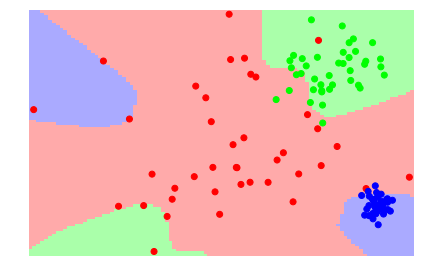

In [20]:
@interact(degree=[0,10])
def plot_poly_svc(degree=3):
    svc_poly = SVC(kernel='poly', degree=degree)
    plot_estimator(svc_poly, X, y)

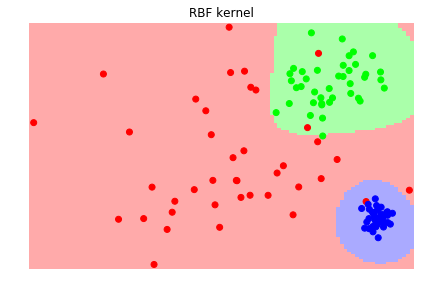

In [21]:
@interact(power=[-2,5])
def plot_rbf_svc(power=1):
    svc_rbf = SVC(kernel='rbf', gamma=10**power)
    plot_estimator(svc_rbf, X, y)
    plt.title('RBF kernel')

## how RBF kernel looks

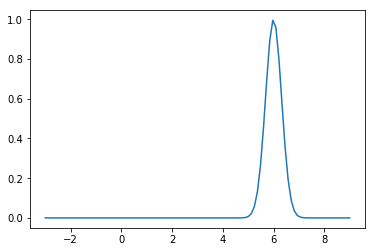

In [22]:
from sklearn.metrics.pairwise import rbf_kernel
line = np.linspace(-3, 9, 100)[:, np.newaxis]
kernel_value = rbf_kernel([[6]], line, gamma=5)
plt.plot(line, kernel_value.T)

Sklearn provides many metrics for evaluating the performance of a classifcation algorithm see http://scikit-learn.org/stable/modules/model_evaluation.html
You can pass in one of these metrics to Sklearns cross-validation functionality so as to to optimize algorithms tunable parameters to the loss you care about. 
For this lab though we will just use them to explore how well we did on the test set

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score 

# Questions for you

* Does tf-idf really helps?
* How number of support vectors depends on C?
* How do you extract parameters of different kinds of SVM?
* Print the proportion of predictions that were correct using accuracy_score(trueY,pred)
* Apply bi-grams to improve accuracy.
* using %timeit magic find how log it takes to compute for different C.

[Download data and notebook](http://bit.ly/2kOA6xY)

[Score board](http://bit.ly/2jOAejv)

In [6]:
class DupleTokenizer(StemmerTokenizer):
    """
    Builds upon the StemmerTokenizer: after all words in a recipe are stemmed
    they are grouped in all possible combinations of two words and added
    to the words' list.
    
    Example (simplified):
    >>> tok = DupleTokenizer()
    >>> tok.tokenizer(
            tok.preprocessor([
                'sugar', 'salt', 'black pepper'
            ])
        )
    ['black', 'pepper', 'salt', 'sugar',
     'black pepper', 'black salt', 'black sugar', 'pepper salt', 'pepper sugar', 'salt sugar']
    """

    def duple(self, x):
        duples = []
        x_len = len(x)
        i = 0
        while i < x_len-1:
            j = i + 1
            while j < x_len:
                duples.append('%s %s' % (x[i], x[j]))
                j = j + 1
            i = i + 1
        return np.array(duples)

    def tokenizer(self, doc):
        words = np.array([self.mapper(t) for t in regexp_tokenize(doc, pattern=self.pattern)])
        words = sorted(set(words))
        words = np.hstack([words, self.duple(words)])
        return words